# 03 Data Assimilation via MSM and HMM

In this final notebook, we show how an "incorrect" MSM can be corrected by integrating experimental observations via HMM

In [1]:
# first, we load packages. This takes time...
using PyPlot, Random
using MDToolbox
ENV["COLUMNS"] = 130; #display width for MDToolbox
Random.seed!(755);

# Load the MSM data constructed in tutorial 01

In [3]:
using JLD2
@load "01_msm.jld2" T p PCA CLUST t

5-element Array{Symbol,1}:
 :T
 :p
 :PCA
 :CLUST
 :t

# "Distort" the original MSM parameters

Here we intentinally "distort" the transition probabilities of the original MSM and generate an "incorrect" MSM for an illustrative purpose of data assimilation. 

In [4]:
nstate = size(T, 1)
T0 = deepcopy(T)
T0[:, 1] .= T0[:, 1]*10
T0 = T0 ./ sum(T0, dims=2)

T0, p0 = msmtransitionmatrix(T0)

10 iteration  LogLikelihood = -6.83594e+01  delta = 7.13803e-02  tolerance = 1.00000e-04
20 iteration  LogLikelihood = -6.80222e+01  delta = 1.79112e-02  tolerance = 1.00000e-04
30 iteration  LogLikelihood = -6.79119e+01  delta = 7.31504e-03  tolerance = 1.00000e-04
40 iteration  LogLikelihood = -6.78612e+01  delta = 3.71830e-03  tolerance = 1.00000e-04
50 iteration  LogLikelihood = -6.78337e+01  delta = 2.14447e-03  tolerance = 1.00000e-04
60 iteration  LogLikelihood = -6.78170e+01  delta = 1.34417e-03  tolerance = 1.00000e-04
70 iteration  LogLikelihood = -6.78062e+01  delta = 8.94489e-04  tolerance = 1.00000e-04
80 iteration  LogLikelihood = -6.77989e+01  delta = 6.23037e-04  tolerance = 1.00000e-04
90 iteration  LogLikelihood = -6.77937e+01  delta = 4.50008e-04  tolerance = 1.00000e-04
100 iteration  LogLikelihood = -6.77899e+01  delta = 3.34851e-04  tolerance = 1.00000e-04
110 iteration  LogLikelihood = -6.77870e+01  delta = 2.55451e-04  tolerance = 1.00000e-04
120 iteration  LogL

([0.6604905930363295 0.007377330765368687 … 0.0004437182792419102 0.0002556722189792165; 0.6321642683356355 0.016387949856950298 … 0.0 0.0; … ; 0.763971314592281 0.0 … 0.0 0.0; 0.6195014032262653 0.0 … 0.0 0.0], [0.6674206500440711, 0.007788771276136578, 0.0007583340928562235, 0.014717176096780304, 0.0007108151150430087, 0.00014772094166988953, 0.015806176428821976, 0.00023259809513328405, 0.0013548290905316593, 0.00015304527017452865  …  0.007803279267995377, 0.00017222564461224983, 0.07586366101558528, 0.014681919490093223, 0.0005692947722384528, 0.00031135982423878756, 0.0002116425429372774, 0.003418783972013478, 0.00038764118064579567, 0.0002754488007624323])

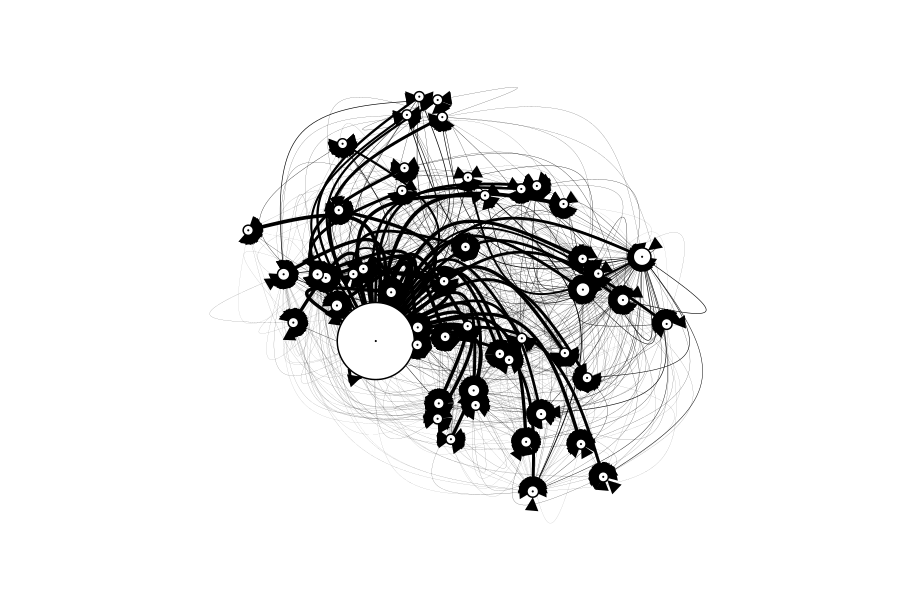

In [5]:
# visualize the "incorrect" MSM
msmplot(T0, x=CLUST.center[:, 1], y=CLUST.center[:, 2], dpi=150)

# Generate "experimental observations" from the original MSM

We generate "experimental observations" from the original MSM.

Here, we mimic single-molecule FRET measurement which can monitor distance between two probes. For simplicity, we don't use any probes, we just monitor the distance between the center of mass coordinates of LID and CORE domains in Adenylate kinase.

Suppose that the distance between LID and CORE can be described by $X_{\rm LID-CORE}$. Then, "experimental observation" is written as similar to the previous tuturial,

\begin{aligned}
Y_{\rm obs} = X_{\rm LID-CORE} + \epsilon
\end{aligned}

\begin{aligned}
\epsilon = Y_{\rm obs} - X_{\rm LID-CORE}
\end{aligned}

Here, $\epsilon$ is a Gaussian random variable whose mean is zero and variance is one. Then, the probability distribution of $Y_{\rm obs}$ is 

\begin{aligned}
P(y_{\rm obs} | X_{\rm LID-CORE}=x_{\rm LID-CORE}) = \frac{1}{\sqrt{2 \pi}} \exp \left( - \frac{(y_{\rm obs}-x_{\rm LID-CORE})^2}{2} \right)
\end{aligned}


In [6]:
# get structures of cluster centers
t_centers = t[CLUST.indexOfCenter, :];

In [7]:
# compute distance between LID and CORE for center structures
com_CORE = centerofmass(t_centers["resid 1:29 68:117 161:214"])
com_LID  = centerofmass(t_centers["resid 18:167"])
distance_centers = compute_distance(com_CORE, com_LID)

50×1 Array{Float64,2}:
 11.971498396746838
 10.656536973945057
 12.912506824157274
  9.82131588876376
 12.008604712605456
 10.406241342124241
  8.133870104836927
  9.581043318216347
 11.45953337877528
 13.244091980937844
 12.415870096860514
 10.001149726080776
 11.778129912871465
  ⋮
 11.292638166274719
 12.286159958680265
 11.812002389485706
 11.661244911511586
  9.43825359455135
 11.970010802812363
 13.473919892050912
  9.504707072865953
 12.074597162676717
  9.886699280794286
 11.994192325722432
 11.095963074093051

In [8]:
# generate experimental observations from Markov chains of the original MSM and gaussian noise
N = 1000
states_ground_truth = msmgenerate(N, T, p)
observations = distance_centers[states_ground_truth] .+ randn(N)

emission_probability = (1.0./sqrt(2.0*pi)) .* exp.( - (observations .- distance_centers').^2 ./ 2.0 )

1000×50 Array{Float64,2}:
 0.309076     0.0508833   0.388835     0.0065911    0.317161     …  0.330939    0.00793183   0.314048     0.112705
 0.216904     0.0213966   0.393681     0.00200191   0.225818        0.241763    0.00247126   0.22235      0.0562395
 0.223911     0.387599    0.0523068    0.223758     0.215009        0.199362    0.239545     0.218459     0.391102
 0.131404     0.00779892  0.343072     0.000528427  0.138779        0.152416    0.000669008  0.135889     0.0242922
 0.118592     0.387366    0.0175875    0.33471      0.111855        0.100463    0.347189     0.114444     0.316139
 0.0805373    0.356561    0.00960799   0.373739     0.075313     …  0.0666178   0.381855     0.0773133    0.262878
 0.336533     0.0658329   0.374218     0.00951486   0.34366         0.355498    0.0113525    0.34093      0.13765
 0.000108875  0.00944175  1.54524e-6   0.0654811    9.36146e-5      7.13222e-5  0.0577039    9.92861e-5   0.00257588
 0.00384192   0.0889804   0.00014026   0.266789    

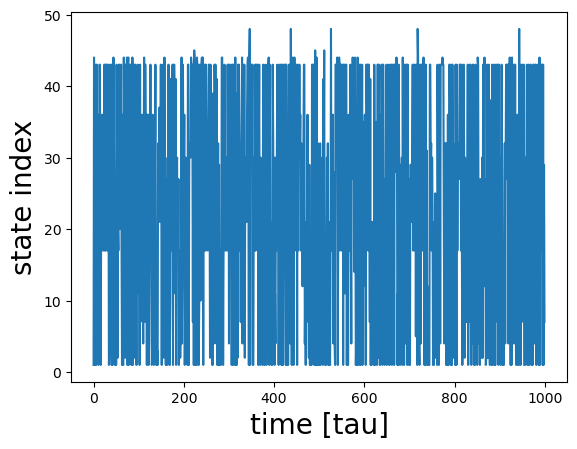

PyObject Text(38.00000000000001, 0.5, 'state index')

In [9]:
plot(states_ground_truth)
xlabel("time [tau]", fontsize=20)
ylabel("state index", fontsize=20)

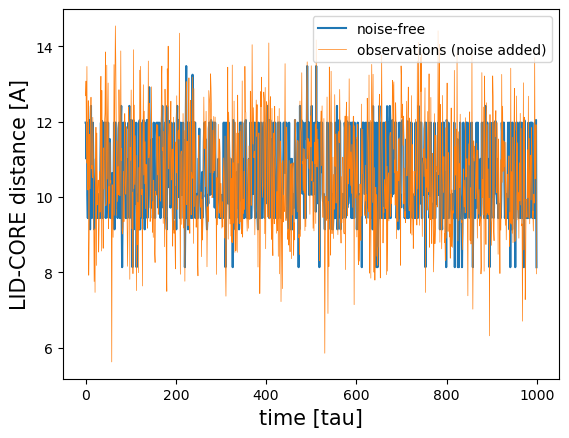

PyObject Text(30.000000000000014, 0.5, 'LID-CORE distance [A]')

In [10]:
plot(distance_centers[states_ground_truth], label="noise-free")
plot(observations, linewidth=0.5, label="observations (noise added)")
legend(loc="upper right")
xlabel("time [tau]", fontsize=15)
ylabel("LID-CORE distance [A]", fontsize=15)

# Correct the "distorted" MSM using experimental observations and HMM

In [11]:
# apply Baum-Welch algorithm and correct the "distorted" transition probabilities
T_estimated, p_estimated, dummy = msmbaumwelch([collect(1:N)], T0, p0, emission_probability', MAXITERATION=300, TOLERANCE=10^(-5))

100 iteration LogLikelihood = -1.813817e+03  delta = 9.485962e-04  tolerance = 1.000000e-05
200 iteration LogLikelihood = -1.812860e+03  delta = 8.911483e-03  tolerance = 1.000000e-05
300 iteration LogLikelihood = -1.812228e+03  delta = 7.683493e-03  tolerance = 1.000000e-05


([0.3977357273737171 0.0030047174590053403 … 9.468822840184952e-17 7.257325777624843e-10; 0.01765977089767559 0.05515446494785411 … 0.0 0.0; … ; 0.0011688581835275196 0.0 … 0.0 0.0; 0.7468513928784616 0.0 … 0.0 0.0], [0.27458719402611714, 0.04671957188403597, 0.00010393270070200035, 2.9225293973743587e-6, 2.1324086026718485e-13, 1.7610932893964786e-13, 0.018610609079914662, 8.097020160395803e-13, 1.0946302558619666e-12, 5.833268091660637e-13  …  6.332540267878806e-9, 1.6764603393536644e-11, 0.23752878468673147, 7.530120140435411e-5, 1.57638366948237e-9, 1.295135882820348e-11, 0.020942579555912957, 6.583238161710268e-5, 2.2244080000964293e-14, 2.668226558072051e-10], [0.30907634207104234 0.2169039969161832 … 0.3983959360945447 0.0001270545199249162; 0.05088334787274991 0.021396568785571685 … 0.1797787248927557 0.010477155625962253; … ; 0.31404766240387605 0.2223495043622265 … 0.3978204296115766 0.00011596504031142623; 0.11270457023878132 0.05623950008042625 … 0.28429209554216905 0.00290

In [12]:
# transition probabilities of the original MSM
T

50×50 Array{Float64,2}:
 0.163215   0.0182578   0.00234881   0.035782   0.00166427   0.000190095  …  0.000313677  0.0099254   0.000803925  0.000459164
 0.146954   0.0380965   0.0024485    0.0405073  0.00236807   0.0             0.00122616   0.0011947   0.0          0.0
 0.250066   0.0323872   0.0          0.0486176  0.0          0.0             0.0          0.0         0.0          0.0
 0.162996   0.0229252   0.00208017   0.0229421  0.00402359   0.0             0.0          0.00608976  0.000711447  0.00203452
 0.13227    0.0233829   0.0          0.0702002  0.0          0.0             0.0          0.0234646   0.0          0.0
 0.0786344  0.0         0.0          0.0        0.0          0.0          …  0.0          0.0         0.0          0.0
 0.268906   0.0176513   0.00181637   0.0335627  0.000877648  0.00110139      0.0          0.00354295  0.000932412  0.00266338
 0.252042   0.0         0.0          0.0        0.0          0.0             0.0          0.0         0.0          0.0
 0

In [13]:
# transition probabilities of the "distorted" MSM
T0

50×50 Array{Float64,2}:
 0.660491  0.00737733  0.000873119  0.0145555   0.000642613  0.000102131  …  0.000211815  0.00406142   0.000443718  0.000255672
 0.632164  0.0163879   0.000976386  0.0174664   0.000977197  0.0             0.000872202  0.000518484  0.0          0.0
 0.768445  0.0100284   0.0          0.0150077   0.0          0.0             0.0          0.0          0.0          0.0
 0.66009   0.00924375  0.000773306  0.00929199  0.00155043   0.0             0.0          0.00247822   0.000388344  0.00112236
 0.603382  0.0107077   0.0          0.0321012   0.0          0.0             0.0          0.0108137    0.0          0.0
 0.461441  0.0         0.0          0.0         0.0          0.0          …  0.0          0.0          0.0          0.0
 0.785583  0.00516369  0.000491044  0.00985011  0.000245982  0.000427757     0.0          0.00104769   0.00037051   0.00106952
 0.773819  0.0         0.0          0.0         0.0          0.0             0.0          0.0          0.0        

In [14]:
# corrected transition probabilities by Baum-Welch (HMM)
T_estimated

50×50 Array{Float64,2}:
 0.397736     0.00300472   3.10901e-15  3.47664e-9   3.96216e-19  …  3.20973e-11  4.13413e-10  9.46882e-17  7.25733e-10
 0.0176598    0.0551545    1.26582e-14  1.76234e-10  2.18069e-16     0.00370279   1.05176e-23  0.0          0.0
 8.21391e-12  5.69007e-12  0.0          4.33508e-20  0.0             0.0          0.0          0.0          0.0
 0.000326649  2.81728e-6   1.54167e-18  8.62946e-7   4.48325e-16     0.0          4.72751e-17  2.68134e-17  6.58785e-7
 5.10201e-7   4.77775e-5   0.0          6.14442e-9   0.0             0.0          0.150313     0.0          0.0
 5.80667e-5   0.0          0.0          0.0          0.0          …  0.0          0.0          0.0          0.0
 6.5591e-5    6.56726e-9   4.24368e-86  8.98305e-6   1.2451e-49      0.0          4.76128e-27  8.0284e-49   1.37231e-34
 3.44223e-10  0.0          0.0          0.0          0.0             0.0          0.0          0.0          0.0
 1.53555e-6   1.10191e-6   0.0          5.79555e-8   2.66

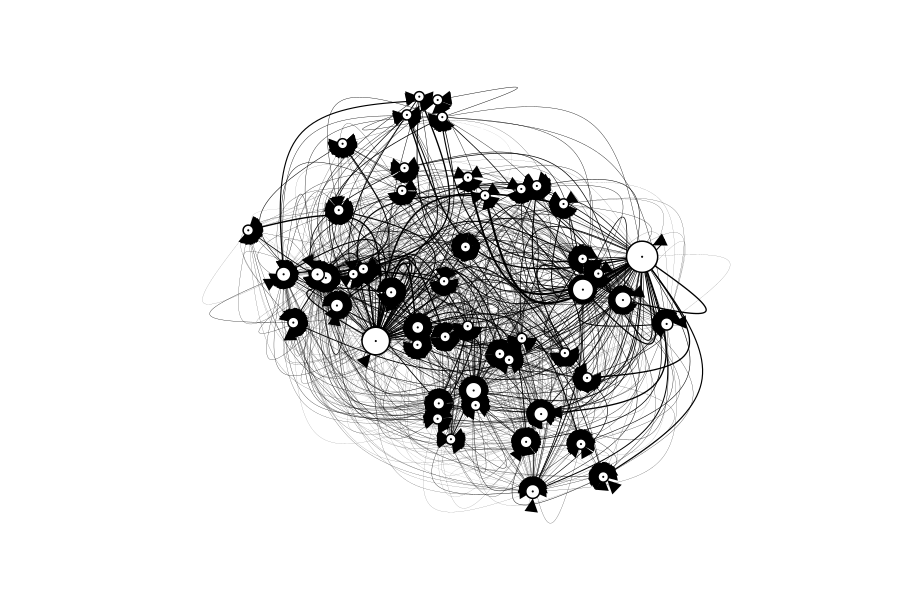

In [15]:
# original MSM
msmplot(T, x=CLUST.center[:, 1], y=CLUST.center[:, 2], filename="03_msm_original.png", dpi=150)

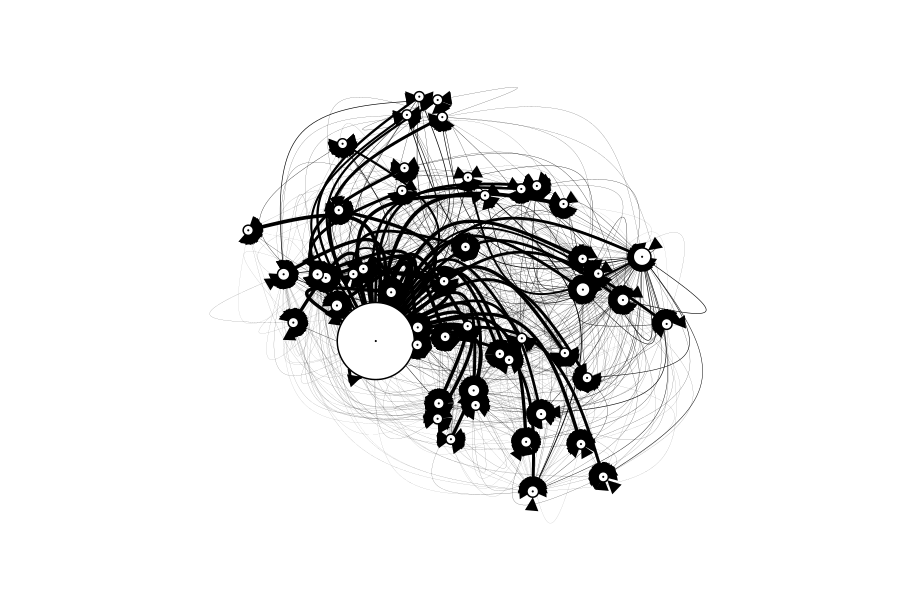

In [16]:
# "distorted" MSM
msmplot(T0, x=CLUST.center[:, 1], y=CLUST.center[:, 2], filename="03_msm_distorted.png", dpi=150)

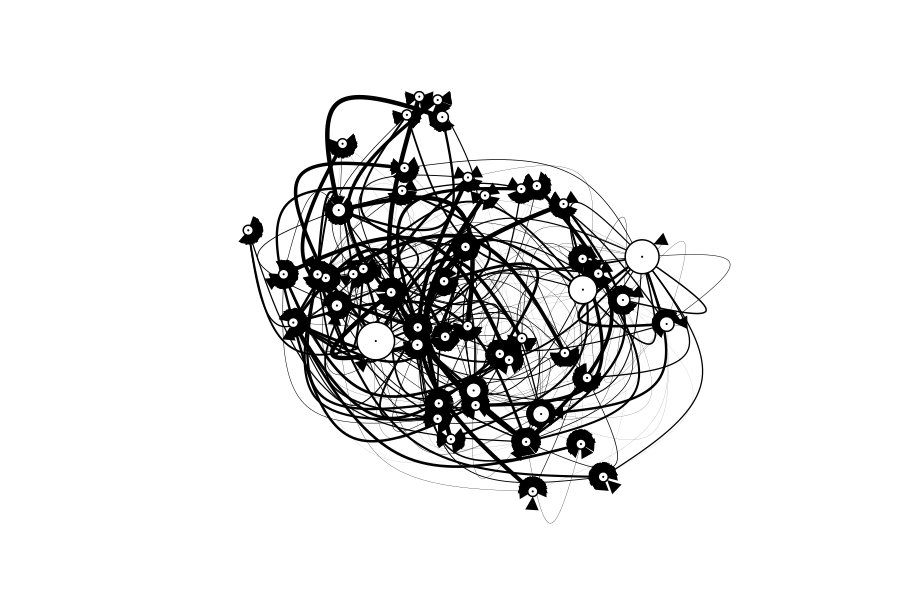

In [17]:
# corrected MSM
msmplot(T_estimated, x=CLUST.center[:, 1], y=CLUST.center[:, 2], filename="03_msm_estimated.png", dpi=150)